<a href="https://colab.research.google.com/github/Rio-HEPLab/EAFEXP2024/blob/main/Simulation_Muon_Flux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import tan, sin, cos, sqrt, atan2, pi, acos
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# Lx: Detector width in x direction
# Ly: Detector width in y direction
# H: Height of top detector with respect to bottom detector
# In cm
Lx = 50.0
Ly = 50.0
H  = 60.0

# Number of tracks to simulate
Ntracks = 100000

def propagate_to_bottom(theta, phi, x0, y0):
    '''
    Propagates a track with given direction and initial position to bottom plane.
    Parameters:
    theta (float): Zenital angle of the track trajectory, in radians.
    phi (float): Azimutal angle of the muon trajectory, in radians.
    x0, y0: X and Y initial track position in top plane.
    Returns:
    x and y position of the track in the bottom plane.
    '''
    d = H*tan( theta )
    deltaX = d*sin( phi )
    deltaY = d*cos( phi )
    x_bot, y_bot = (x0 + deltaX, y0 + deltaY)

    return x_bot, y_bot

# Cumulative distribution of cos^2(x)
def F( x ):
    return ( 2. / pi ) * ( x + np.cos( x ) * np.sin( x ) )

def random_tracks( Ntracks ):
    '''
    Generates random tracks according to a cos²(theta) propability.
    Parameters:
    Ntracks: Number of tracks to generate.
    Returns:
    Arrays of zenithal angle, azimuthal angle, x and y positions.
    '''

    theta = [] #zenital angle
    phi = [] #azimutal angle
    x = [] #position in x
    y = [] #position in y

    for i in range( 0, Ntracks ):
        if i % 50000 == 0:
            print ( "Processing track number {}".format( (i+1) ) )

        # Sample cumulative distribution and invert
        # val_y = np.random.rand()
        # opt_sol = optimize.root_scalar( ( lambda x: F( x ) - val_y ) , bracket=(0,pi/2) )
        # one_theta = opt_sol.root

        # Acceptance/rejection
        one_theta = -999.
        while True:
            sample_theta_ = np.random.rand() * ( pi / 2 )
            sample_y_ = np.random.rand()
            cos2theta_ = cos( sample_theta_ ) ** 2
            # cos2theta_ = cos( sample_theta_ ) ** 2.5
            if sample_y_ < cos2theta_:
                one_theta = sample_theta_
                break

        one_phi = np.random.rand() * ( 2*pi - 0 )

        one_x = np.random.uniform( 0, Lx )
        one_y = np.random.uniform( 0, Ly )

        theta.append(one_theta)
        phi.append(one_phi)
        x.append(one_x)
        y.append(one_y)

    return theta, phi, x, y

In [2]:
# Run simulation

x_bot_all = []
y_bot_all = []

theta, phi, x, y = random_tracks( Ntracks )
count_tracks_in_acceptance = 0
theta_acc = []
for theta_, phi_, x0_, y0_ in zip(theta, phi, x, y):
    # Propagate track positions in bottom detector
    x_bot_rndm, y_bot_rndm = propagate_to_bottom( theta_, phi_, x0_, y0_ )
    # Save positions in arrays
    x_bot_all.append( x_bot_rndm )
    y_bot_all.append( y_bot_rndm )
    # Check if within acceptance of bottom detector
    if 0. < x_bot_rndm and x_bot_rndm < Lx:
        if 0 < y_bot_rndm and y_bot_rndm < Ly:
            count_tracks_in_acceptance += 1
            theta_acc.append( theta_ )

print ( "Number of tracks in acceptance: {} / {}".format( count_tracks_in_acceptance, Ntracks ) )

Processing track number 1
Processing track number 50001
Number of tracks in acceptance: 41799 / 100000


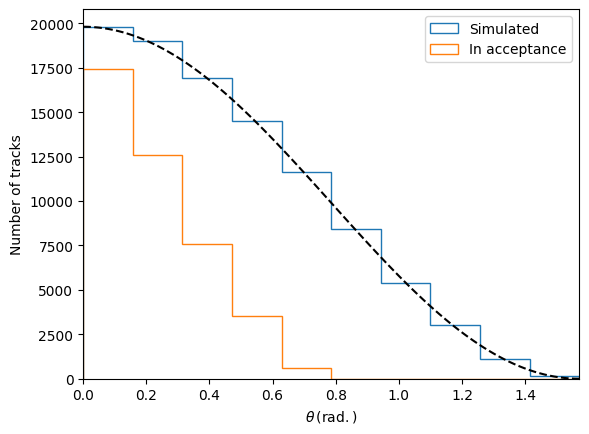

In [3]:
fig = plt.figure()
counts, _, __ = plt.hist( theta, range=(0,pi/2), bins=10, histtype='step', label="Simulated" )
plt.hist( theta_acc, range=(0,pi/2), bins=10, histtype='step', label="In acceptance" )
X__ = np.linspace( 0., pi/2, 100 )
plt.plot( X__, np.max( counts ) * ( np.cos( X__ ) ** 2 ), 'k--' )
plt.xlim(0.,pi/2)
plt.xlabel(r'$\theta \,(\rm{rad.})$')
plt.ylabel('Number of tracks')
plt.legend( loc='best' )

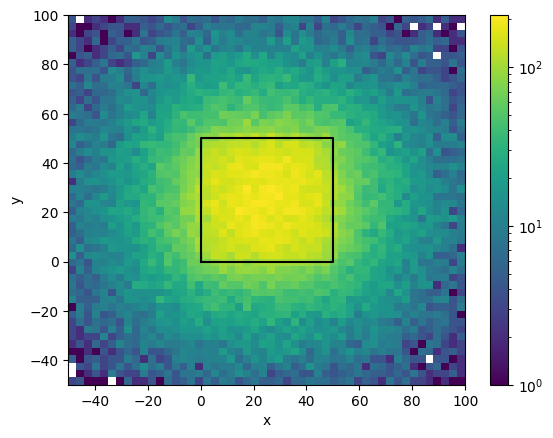

In [4]:
from matplotlib.colors import LogNorm
fig = plt.figure()
counts, xedges, yedges, im = plt.hist2d( x_bot_all, y_bot_all, bins=(50,50), range=( (-50.,100.), (-50.,100.) ), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=plt.gca())
plt.plot( [ 0., Lx, Lx, 0., 0. ], [0., 0., Ly, Ly, 0. ], 'k-' )
plt.xlim(-50,100)
plt.ylim(-50,100)
plt.xlabel('x')
plt.ylabel('y')
plt.show()